Полезная лекция про временные ряды: https://www.youtube.com/watch?v=u433nrxdf5k .

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

Проведем подготовку к проекту. Загрузим данные и выполним их ресемплирование по одному часу.

Для этого укажем библиотеки, которые будут использованы с ходе работы, зададим параметры, укажем путь к файлу в виде константы.

In [1]:
#import sys
#!{sys.executable} -m pip install xgboost

In [2]:
import pandas as pd
import matplotlib.pyplot as plt 
from matplotlib import colors

import numpy as np
import warnings
from IPython.display import Markdown, display

from statsmodels.tsa.seasonal import seasonal_decompose
from pandas_profiling import ProfileReport
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
%matplotlib inline

FILE_PATH = 'taxi.csv'

/opt/anaconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


Подготовим функции, которые понадобятся для выполнения работы.

In [3]:
#функция для вывода текста с возможностью выделения
def printmd(string):
    display(Markdown(string))

#функция на построения графика важности признаков при обучении модели    
def ShowImportances(columns, importances):
    rf_importances_df = pd.DataFrame(
    data={'features':columns,'importances': importances})\
    .sort_values('importances', ascending = False).reset_index()
    plt.figure(figsize=(16,4))
    plt.bar(rf_importances_df['features'], rf_importances_df['importances'], color='#B0C4DE')
    plt.xticks(rotation=90)
    plt.title("Важность признаков")
    plt.show()     

#функция добавления новых признаков в набор данных
def make_features(dataset, max_lag, max_lag_h, rolling_mean_size):
    #dataset['year'] = dataset.index.year #не влияет, так как в выборке только 1 значение
    dataset['month'] = dataset.index.month #не оказывает существенного влияния
    #dataset['day'] = dataset.index.day #не оказывает существенного влияния
    dataset['dayofweek'] = dataset.index.dayofweek #не оказывает существенного влияния, но оставим
    dataset['hour'] = dataset.index.hour 
    
    for lag in range(1, max_lag + 1):
        dataset['lag_{}'.format(lag*168)] = dataset['num_orders'].shift(lag*168)
    
    #данные по предыдущим часам влияют на результат
    #for lag in range(1, max_lag_h + 1):
    #    dataset['lag_h_{}'.format(lag)] = dataset['num_orders'].shift(lag)
    
    dataset['rolling_mean_336h'] = dataset['num_orders'].shift(336).rolling(rolling_mean_size).mean()
    dataset['rolling_mean_168h'] = dataset['num_orders'].shift(168).rolling(rolling_mean_size).mean()
    #dataset['rolling_mean_24h'] = dataset['num_orders'].shift(24).rolling(rolling_mean_size).mean()
    #dataset['rolling_mean'] = dataset['num_orders'].shift(1).rolling(rolling_mean_size).mean()
    
    dataset['trend_lag168'] = dataset['trend'].shift(168)
    dataset['seasonal_lag168'] = dataset['seasonal'].shift(168)
    dataset['resid_lag168'] = dataset['resid'].shift(168)
    
    dataset = dataset.drop(['trend','seasonal','resid'], axis=1)
    return dataset

#функция визуализации предсказаний 
def ShowTargetPredPlot(indexes, target, pred):
    plt.figure(figsize=(6,4))
    plt.hist2d(target,pred, bins=(100, 100), norm=colors.LogNorm())
    plt.title('num orders')
    plt.xlabel('target')
    plt.ylabel('pred')
    plt.show()
    
    plt.figure(figsize=(16,4))
    plt.scatter(indexes, target,color='g')
    plt.plot(indexes, pred,color='k')
    plt.legend(('target', 'pred'), loc='upper left', shadow=True)
    plt.title('num orders')
    plt.xlabel('num orders')
    plt.ylabel('index')
    plt.xlim([indexes[0], indexes[-1]])
    plt.show()

Загрузим данные и проведем ресемплирование

In [4]:
data = pd.read_csv(FILE_PATH, index_col=[0], parse_dates=[0])
data.columns = map(str.lower, data.columns)
data.sort_index(inplace=True)
data = data.resample('1H').sum() 

Посмотрим отчет по данным

In [5]:
profile = ProfileReport(data, title="Заказы такси в аэропортах")
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Посмотрим структуру данных 

In [6]:
printmd("**Заказы такси в аэропортах**")
printmd("**Размер**")
print(data.shape)
printmd("**Структура данных**")
data.info()
printmd("**Пустые значения**")
print(data.isna().sum())
display(data.describe())
printmd("**Топ 10 строк**")
display(data.head(10))

**Заказы такси в аэропортах**

**Размер**

(4416, 1)


**Структура данных**

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


**Пустые значения**

num_orders    0
dtype: int64


,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


**Топ 10 строк**

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
2018-03-01 05:00:00,6
2018-03-01 06:00:00,12
2018-03-01 07:00:00,15
2018-03-01 08:00:00,34


## Анализ

In [7]:
display(data.iloc[1])
display(data.iloc[-1])

num_orders    85
Name: 2018-03-01 01:00:00, dtype: int64

num_orders    205
Name: 2018-08-31 23:00:00, dtype: int64

Получается, что у нас есть выборка за период с марта по август 2018 года включительно. Посмотрим, можно ли за такой период выявить сезонность и тренд. Построим за период - август 2018

Посмотрим, как менялось скользящее среднее, медиана и стандартное отклонение

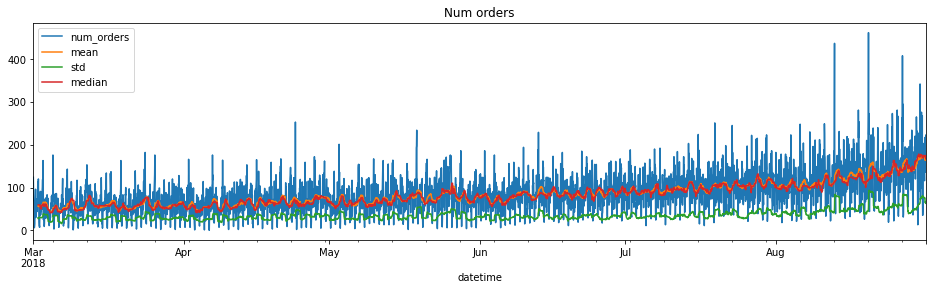

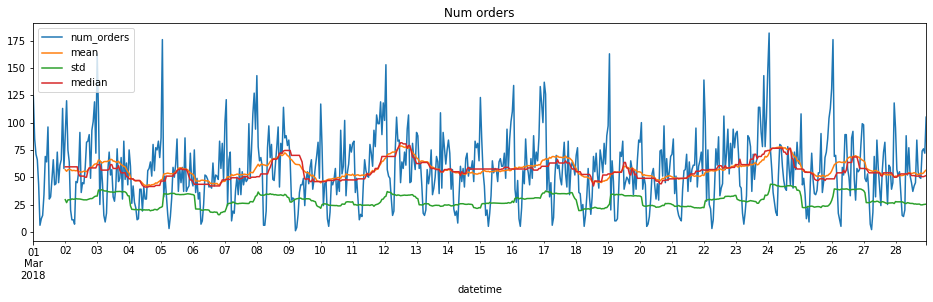

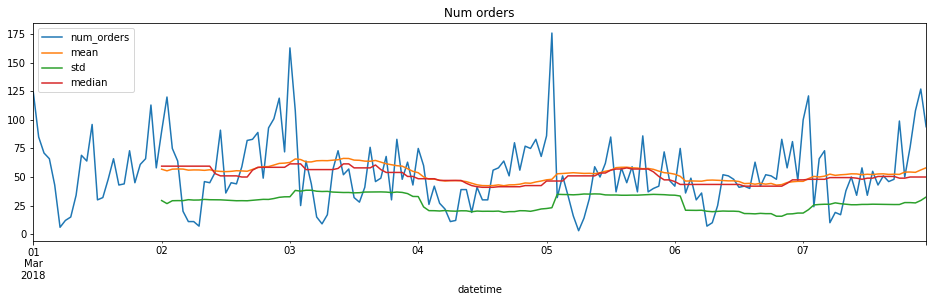

In [8]:
data['mean'] = data['num_orders'].shift().rolling(24).mean()
data['std'] = data['num_orders'].shift().rolling(24).std()
data['median'] = data['num_orders'].shift().rolling(24).median()
data.plot(figsize=(16, 4))
plt.title('Num orders')
plt.show()

data[:672].plot(figsize=(16, 4))
plt.title('Num orders')
plt.show()

data[:168].plot(figsize=(16, 4))
plt.title('Num orders')
plt.show()

data = data.drop(['mean','std','median'], axis=1)

Посмотрим, как менялось скользящее среднее, медиана и стандартное отклонение

In [9]:
decomposed = seasonal_decompose(data)
data['trend'] = decomposed.trend
data['seasonal'] = decomposed.seasonal
data['resid'] = decomposed.resid
data['detranded'] = data['num_orders'] - data['trend']
data['deseasonalized'] = data['num_orders'] / data['seasonal']

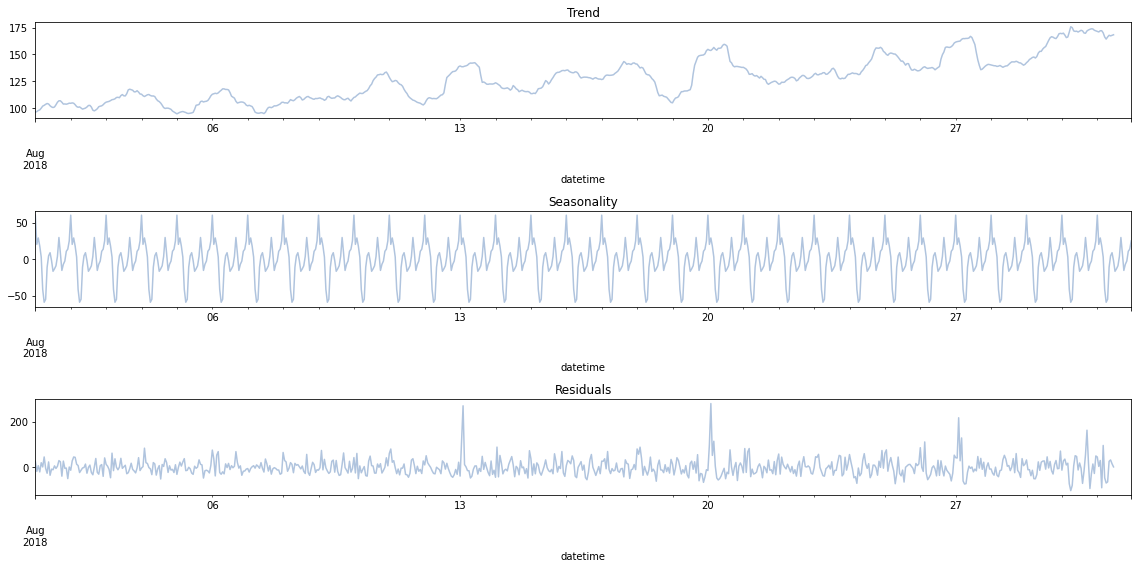

In [10]:
plt.figure(figsize=(16, 8))
plt.subplot(311)
data['2018-08':'2018-08']['trend'].plot(ax=plt.gca(), color='#B0C4DE')
plt.title('Trend')
plt.subplot(312)
data['2018-08':'2018-08']['seasonal'].plot(ax=plt.gca(), color='#B0C4DE')
plt.title('Seasonality')
plt.subplot(313)
data['2018-08':'2018-08']['resid'].plot(ax=plt.gca(), color='#B0C4DE')
plt.title('Residuals')
plt.tight_layout()
plt.show()

По графикам наблюдается общее увеличение количества заказов со временем, а так же циклично повторяющиеся закономерности - нарастание и спад количества заказов в определенные часы и дни недели

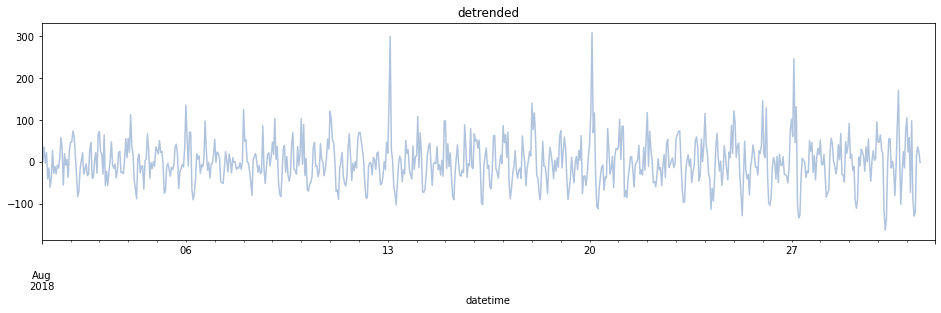

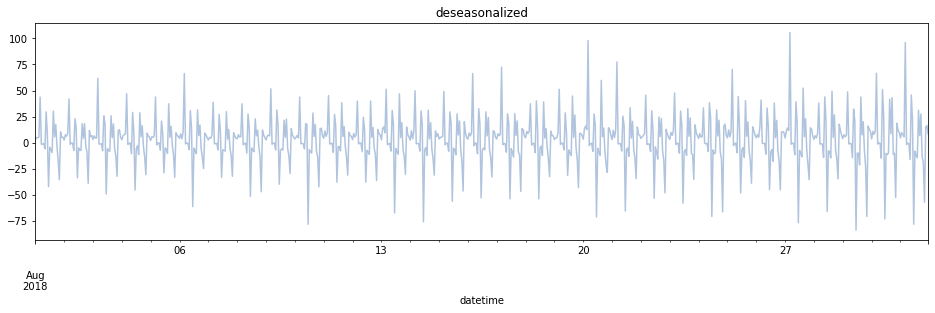

In [11]:
data['detranded']['2018-08':'2018-08'].plot(figsize=(16, 4), color='#B0C4DE')
plt.title('detrended')
plt.show()

data['deseasonalized']['2018-08':'2018-08'].plot(figsize=(16, 4), color='#B0C4DE')
plt.title('deseasonalized')
plt.show()

Посмотрим, как влияют лаги, какой период оказывает большее влияние

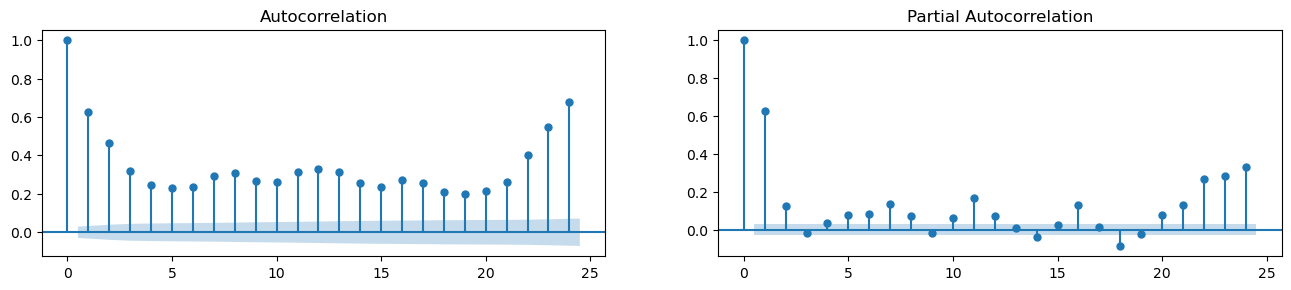

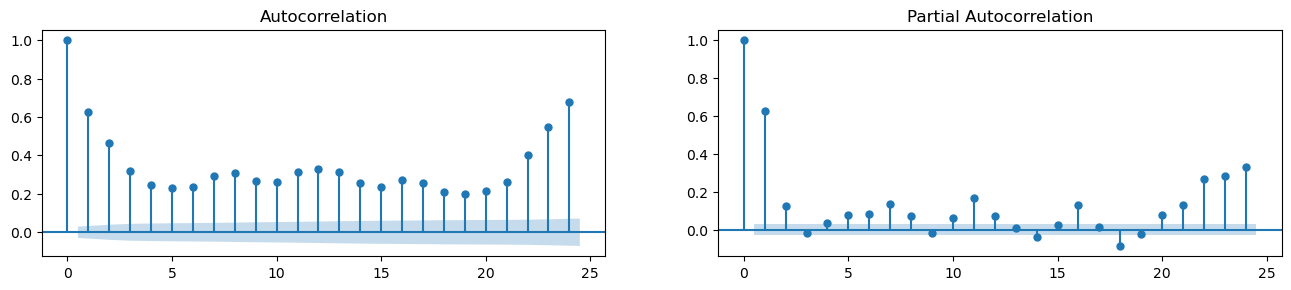

In [12]:
fig, axes = plt.subplots(1,2,figsize=(16,3), dpi= 100)
plot_acf(data['num_orders'].tolist(), lags=24, ax=axes[0])
plot_pacf(data['num_orders'].tolist(), lags=24, ax=axes[1])

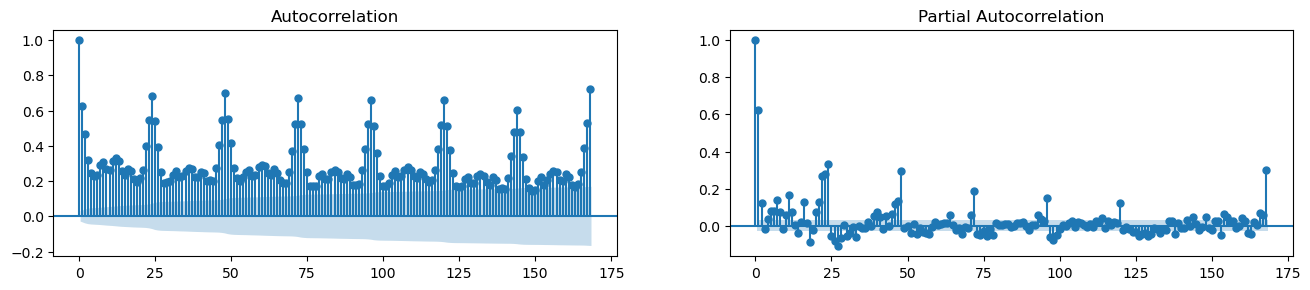

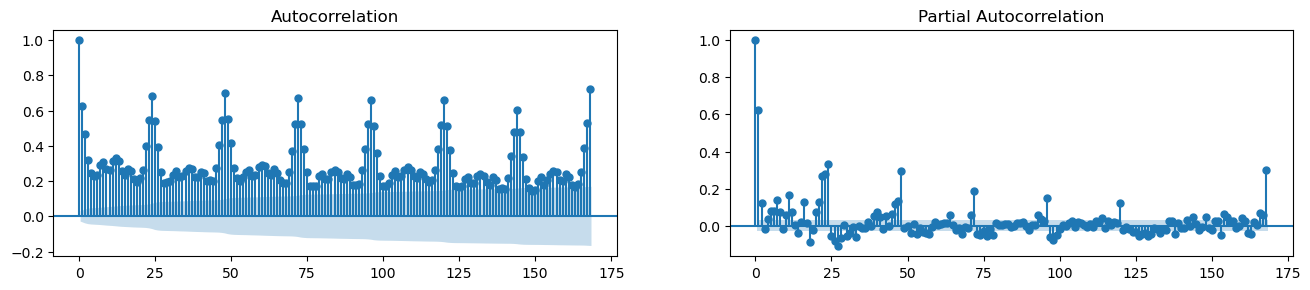

In [13]:
fig, axes = plt.subplots(1,2,figsize=(16,3), dpi= 100)
plot_acf(data['num_orders'].tolist(), lags=168, ax=axes[0])
plot_pacf(data['num_orders'].tolist(), lags=168, ax=axes[1])

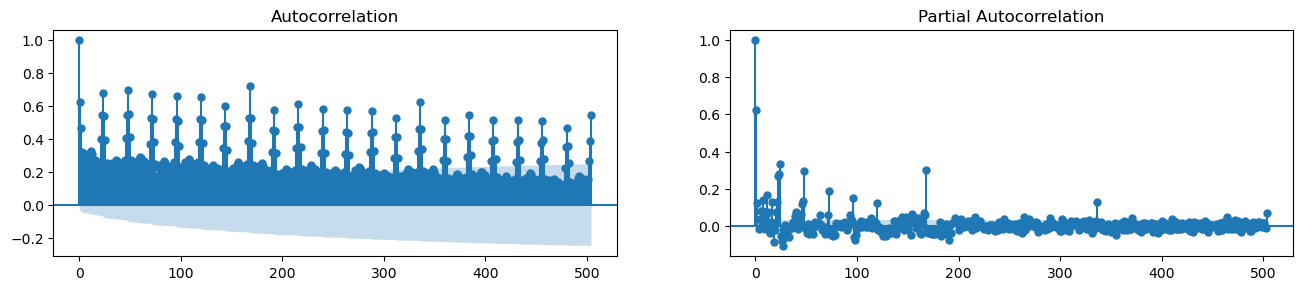

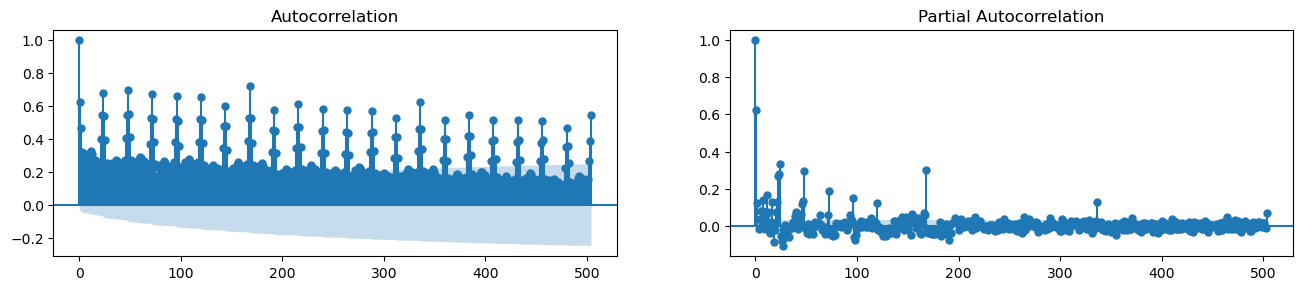

In [14]:
fig, axes = plt.subplots(1,2,figsize=(16,3), dpi= 100)
plot_acf(data['num_orders'].tolist(), lags=504, ax=axes[0])
plot_pacf(data['num_orders'].tolist(), lags=504, ax=axes[1])

Видим зависимость от лага в 24, 48, 72 (в этот час день, два, три и т.д. назад) и т.д. часа, чуть более выраженная зависимость от 168, 336, 504 часа (в этот час неделю, две, ри и т.д. назад). Учтем при добавлении признаков.

deseasonalized и detranded исключаем, так как их добавление ведет к увеличению RMSE

In [15]:
data = data.drop(['detranded','deseasonalized'], axis=1)

## Обучение

In [16]:
data = make_features(data, 4, 3, 2)

In [17]:
train, test = train_test_split(data, shuffle=False, test_size=0.1)
train = train.dropna()

features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']

features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']
features_test = features_test.fillna(0)

In [18]:
%%time
lr_model = LinearRegression()
lr_model.fit(features_train,target_train)

CPU times: user 12.3 ms, sys: 5.73 ms, total: 18 ms
Wall time: 6.4 ms


LinearRegression()

In [19]:
%%time
rf_model = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=20,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=500,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

rf_model.fit(features_train,target_train)

CPU times: user 8.64 s, sys: 329 ms, total: 8.97 s
Wall time: 7.75 s


RandomForestRegressor(criterion='mse', max_depth=20, n_estimators=500)

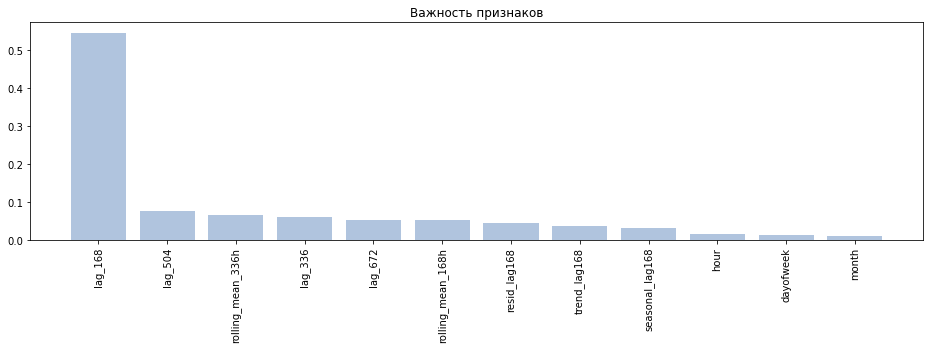

In [20]:
ShowImportances(features_train.columns,rf_model.feature_importances_)

In [21]:
%%time
LGBMR_model = LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=50, objective=None,
              random_state=0, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)
LGBMR_model.fit(features_train, target_train)

CPU times: user 1.14 s, sys: 187 ms, total: 1.32 s
Wall time: 208 ms


LGBMRegressor(num_leaves=50, random_state=0)

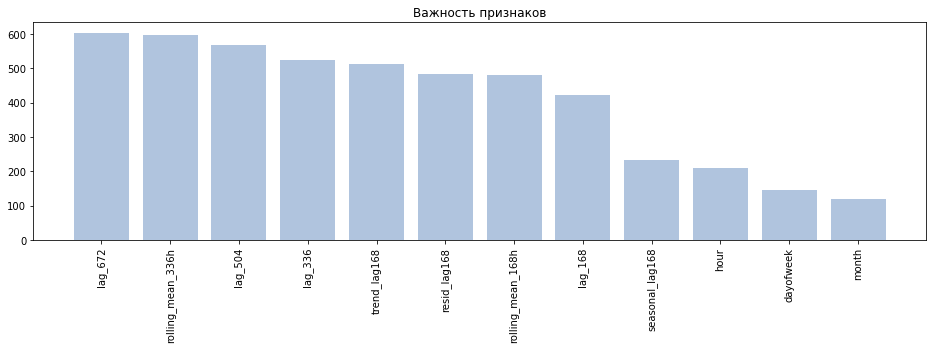

In [22]:
ShowImportances(features_train.columns,LGBMR_model.feature_importances_)

In [23]:
%%time
XGBR_model = XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=1, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:squarederror', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)
XGBR_model.fit(features_train, target_train)

CPU times: user 593 ms, sys: 163 ms, total: 756 ms
Wall time: 214 ms


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type='gain',
             interaction_constraints='', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=1,
             monotone_constraints='()', n_estimators=100, n_jobs=1, nthread=1,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=0, silent=None, subsample=1,
             tree_method='exact', validate_parameters=1, ...)

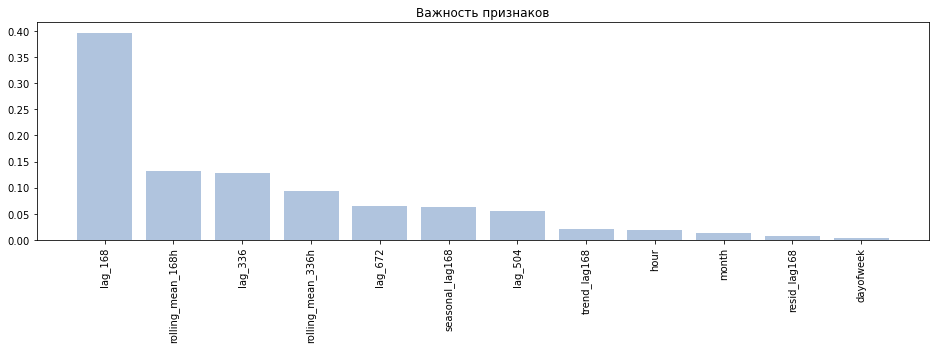

In [24]:
ShowImportances(features_train.columns,XGBR_model.feature_importances_)

Подбор гиперпараметров для обучения

In [25]:
#tscv = TimeSeriesSplit(n_splits=5)

In [26]:
#%%time
#rfr_parameters = {#'bootstrap': [True, False],
# 'max_depth': [5, 20, None],
# #'max_features': ['auto', 'sqrt'],
# #'min_samples_leaf': [1, 2, 4],
# #'min_samples_split': [2, 5, 10],
# 'n_estimators': [100, 500]}

#clf = GridSearchCV(RandomForestRegressor(), rfr_parameters, cv=tscv)
#clf.fit(features_train, target_train)
#print("Параметры:",clf.best_estimator_)
#print("Критерий:", clf.best_score_)

In [27]:
#%%time
#params = {
#    'boosting_type': ['gbdt','dart', 'goss'],
#    #'num_leaves': [7, 14, 21, 28, 31, 50],
#    'learning_rate': [0.01, 0.001, 1.0],
#    #0.001,
#    'max_depth': [-1, 10, 20, 50],
#    'n_estimators': [100, 500]
#}

#LGBMR_grid = GridSearchCV(LGBMRegressor(random_state=0), params, scoring='neg_mean_squared_error', cv=tscv)
#LGBMR_grid.fit(features_train, target_train)

#lgbm_tuned = LGBMR_grid.best_estimator_

#print(LGBMR_grid.best_params_)
#print(LGBMR_grid.best_estimator_)

In [28]:
#%%time
#XGBR_params = {
#    'learning_rate': [0.01, 0.001, 1.0],
#    'max_depth': range(1, 10, 1),
#    'n_estimators': range(0, 100, 25)
#}

#XGBR_grid = GridSearchCV(XGBRegressor(random_state=0), params, scoring='neg_mean_squared_error', cv=tscv)
#XGBR_grid.fit(features_train, target_train)

#XGBR_tuned = grid.best_estimator_

#print(XGBR_grid.best_params_)
#print(XGBR_grid.best_estimator_)

## Тестирование

Создадим таблицу результатов и сохраним в нее класс, который использовался для модели, среднее количество заказов на тестовой выборке, RMSE на обучающей выборке, RMSE на тестовой выборке, процент RMSE от среднего на тестовой выборке, WALL TIME обучения и WALL TIME предсказания.

In [29]:
results_df = pd.DataFrame(data={},
                        columns=['Method',
                                 'Mean test',
                                 'RMSE train',
                                 'RMSE test',
                                 'RMSE test %',
                                 'Time Fit',
                                 'Time Pred'
                                ])

Получим предсказания по LinearRegression

In [30]:
%%time
lr_train_pred = lr_model.predict(features_train)
lr_test_pred = lr_model.predict(features_test)

CPU times: user 2.12 ms, sys: 477 µs, total: 2.6 ms
Wall time: 2.15 ms


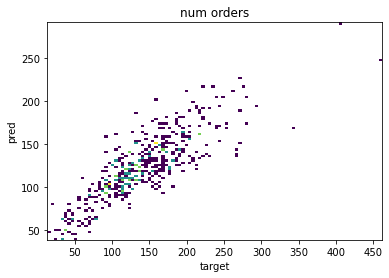

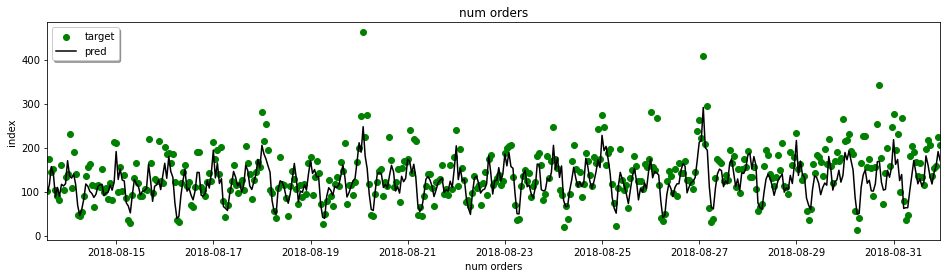

In [31]:
ShowTargetPredPlot(features_test.index, target_test, lr_test_pred)

In [32]:
results_df = results_df.append({'Method': 'LinearRegression',
                                 'Mean test': round(test['num_orders'].mean(),2),
                                 'RMSE train': round(mean_squared_error(target_train, lr_train_pred)**0.5,2),
                                 'RMSE test': round(mean_squared_error(target_test, lr_test_pred)**0.5,2),
                                 'RMSE test %': round(100*(mean_squared_error(target_test, lr_test_pred)**0.5) / test['num_orders'].mean(),2),
                                 'Time Fit': '3.89 ms',
                                 'Time Pred':'29.1 ms'
                           }, ignore_index=True)

Получим предсказания по RandomForestRegressor

In [33]:
%%time
rf_train_pred = rf_model.predict(features_train)
rf_test_pred = rf_model.predict(features_test)

CPU times: user 250 ms, sys: 4.91 ms, total: 255 ms
Wall time: 254 ms


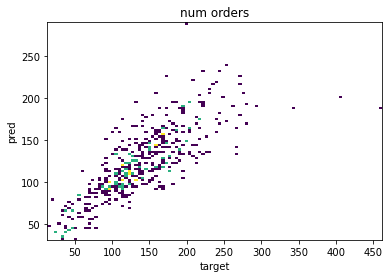

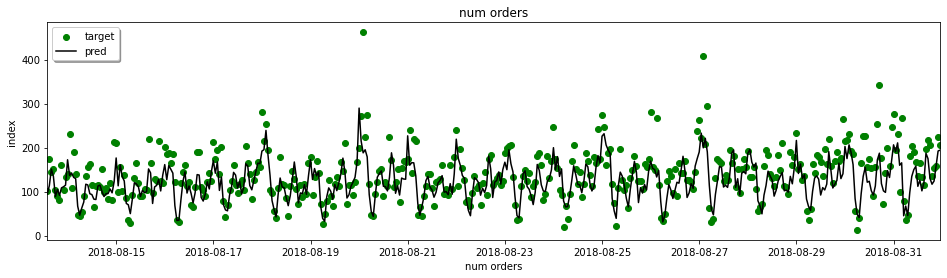

In [34]:
ShowTargetPredPlot(features_test.index, target_test, rf_test_pred)

In [35]:
results_df = results_df.append({'Method': 'RandomForestRegressor',
                                 'Mean test': round(test['num_orders'].mean(),2),
                                 'RMSE train': round(mean_squared_error(target_train, rf_train_pred)**0.5,2),
                                 'RMSE test': round(mean_squared_error(target_test, rf_test_pred)**0.5,2),
                                 'RMSE test %': round(100*(mean_squared_error(target_test, rf_test_pred)**0.5) / test['num_orders'].mean(),2),
                                 'Time Fit': '12.2 s',
                                 'Time Pred':'345 ms'
                           }, ignore_index=True)

Получим предсказания по LGBMRegressor

In [36]:
%%time
LGBMR_train_pred = LGBMR_model.predict(features_train)
LGBMR_test_pred = LGBMR_model.predict(features_test)

CPU times: user 68.1 ms, sys: 1.43 ms, total: 69.5 ms
Wall time: 68.3 ms


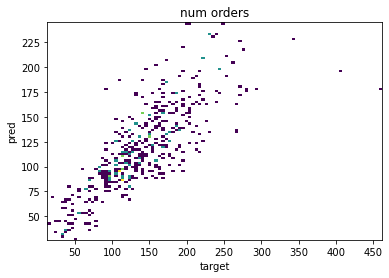

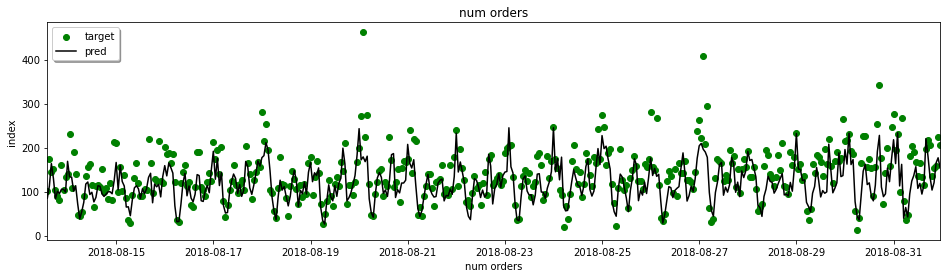

In [37]:
ShowTargetPredPlot(features_test.index, target_test, LGBMR_test_pred)

In [38]:
results_df = results_df.append({'Method': 'LGBMRegressor',
                                 'Mean test': round(test['num_orders'].mean(),2),
                                 'RMSE train': round(mean_squared_error(target_train, LGBMR_train_pred)**0.5,2),
                                 'RMSE test': round(mean_squared_error(target_test, LGBMR_test_pred)**0.5,2),
                                 'RMSE test %': round(100*(mean_squared_error(target_test, LGBMR_test_pred)**0.5) / test['num_orders'].mean(),2),
                                 'Time Fit': '13.1 s',
                                 'Time Pred':'324 ms'
                           }, ignore_index=True)

Получим предсказания по XGBRegressor

In [39]:
%%time
XGBR_train_pred = XGBR_model.predict(features_train)
XGBR_test_pred = XGBR_model.predict(features_test)

CPU times: user 7.85 ms, sys: 1.42 ms, total: 9.27 ms
Wall time: 7.59 ms


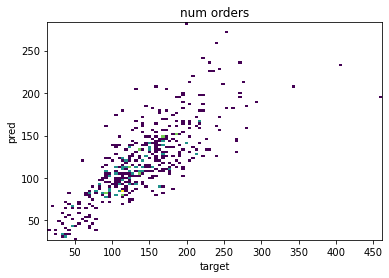

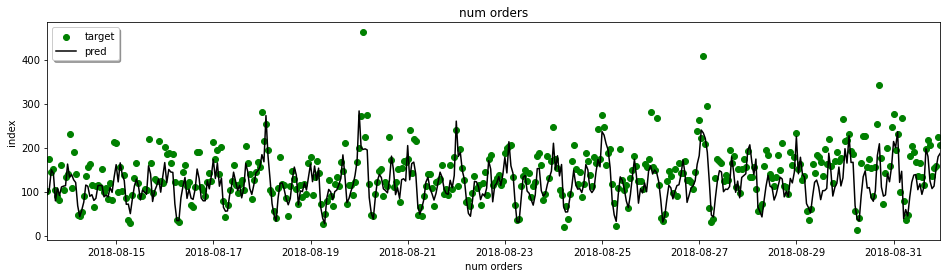

In [40]:
ShowTargetPredPlot(features_test.index, target_test, XGBR_test_pred)

In [41]:
results_df = results_df.append({'Method': 'XGBRegressor',
                                 'Mean test': round(test['num_orders'].mean(),2),
                                 'RMSE train': round(mean_squared_error(target_train, XGBR_train_pred)**0.5,2),
                                 'RMSE test': round(mean_squared_error(target_test, XGBR_test_pred)**0.5,2),
                                 'RMSE test %': round(100*(mean_squared_error(target_test, XGBR_test_pred)**0.5) / test['num_orders'].mean(),2),
                                 'Time Fit': '174 ms',
                                 'Time Pred':'11.2 ms'
                           }, ignore_index=True)

Посмотрим общие результаты

In [42]:
display(results_df.sort_values('RMSE test %'))

,Method,Mean test,RMSE train,RMSE test,RMSE test %,Time Fit,Time Pred
0,LinearRegression,139.56,21.47,37.62,26.96,3.89 ms,29.1 ms
1,RandomForestRegressor,139.56,8.17,39.62,28.39,12.2 s,345 ms
2,LGBMRegressor,139.56,11.52,41.43,29.69,13.1 s,324 ms
3,XGBRegressor,139.56,18.64,41.65,29.84,174 ms,11.2 ms


Наиболее точные предсказания:

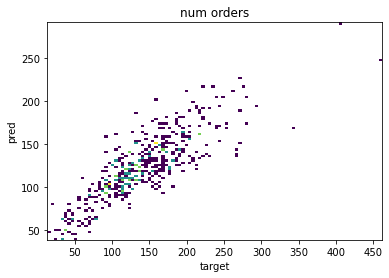

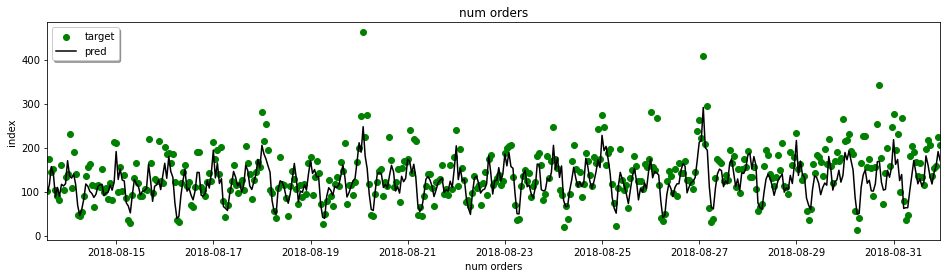

In [43]:
ShowTargetPredPlot(features_test.index, target_test, lr_test_pred)

Значения RMSE на при тестировании близки, при выборе модели необходимо опираться на критерии заказчика: с учетом времени обучения и времени предсказания.

## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Данные загружены и подготовлены
- [x]  Данные проанализированы
- [x]  Модель обучена, гиперпараметры подобраны
- [x]  Качество моделей проверено, выводы сделаны
- [x]  Значение *RMSE* на тестовой выборке не больше 48